In [28]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torchsummary import summary
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchvision.datasets import ImageFolder
from tqdm import notebook
from torch.utils.data import DataLoader, random_split
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import time
import os
import copy
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report,precision_recall_curve

# Data

In [29]:
data_dir='G:\Vinay_Canabis\Lead_II'
print(os.listdir(data_dir))

['0', '1']


In [30]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


In [31]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(size=(224,224)),
                transforms.Normalize((0.3433, 0.7419, 0.5770), (0.3453, 0.0661, 0.2652))
                ])

In [32]:
dataset=ImageFolder(data_dir,transform=transform)
torch.manual_seed(42)
train_ds, val_ds, test_ds = random_split(dataset, [0.8,0.15,0.05])
len(train_ds),len(val_ds),len(test_ds)

(4867, 912, 304)

In [33]:
trainloader =DataLoader(train_ds, batch_size=32, shuffle=True,num_workers=4)
valloader = DataLoader(val_ds, batch_size=32, shuffle=True,num_workers=4)

In [34]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    model.eval()
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [35]:
def train_func(model, loss_fn, opt, trainloader, valloader, scheduler , epochs):
    loss_epoch_arr = []
    train_accuracy_lis = []
    val_accuracy_lis = []
    val_loss_epoch_arr = []

    max_epochs = epochs
    min_loss = 1000
    model.train()

    for epoch in notebook.tqdm(range(max_epochs), total=max_epochs, unit="epochs"):
        model.train()
        for i, data in enumerate(trainloader, 0):
    
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            opt.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()

            if min_loss > loss.item():
                min_loss = loss.item()
                best_model = copy.deepcopy(model.state_dict())
                print("Min loss %0.2f" %min_loss)
            del inputs, labels, outputs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            if i % 2000 == 0:
                print('Iteration: %d, Loss: %0.2f' % (i, loss.item()))
            
       
        loss_epoch_arr.append(loss.item())
        train_accuracy = evaluation(trainloader, model)
        val_accuracy = evaluation(valloader, model)
        print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
              epoch, max_epochs, val_accuracy, train_accuracy))
        train_accuracy_lis.append(train_accuracy)
        val_accuracy_lis.append(val_accuracy)
    
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

        del inputs, labels, outputs
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        val_loss_epoch_arr.append(loss.item())
    return best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr

In [36]:
def generate_classification_report(model, dataloader, device, filepath):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()

    report = classification_report(all_labels, all_preds, target_names=[str(i) for i in range(len(set(all_labels)))])

    # Save the classification report to a text file
    with open(filepath, 'w') as f:
        f.write(report)
    
    print(f"Classification report saved to '{filepath}'")

In [37]:
def plot_evaluation_metrics(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.append(preds)
            all_labels.append(labels)

    all_preds = torch.cat(all_preds).cpu().numpy()
    all_labels = torch.cat(all_labels).cpu().numpy()
    return all_preds, all_labels

# Resnet50

In [38]:
resnet = models.resnet50(weights=True)

In [39]:
for param in resnet.parameters():
    param.requires_grad=True

In [40]:
num_features = resnet.fc.in_features
new_classifier = nn.Sequential(
    nn.Linear(num_features, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2))
resnet.fc = new_classifier

In [41]:
resnet =resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.0001)
summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [42]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)


In [43]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(resnet, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

  0%|          | 0/50 [00:00<?, ?epochs/s]

Min loss 0.69
Iteration: 0, Loss: 0.69
Min loss 0.67
Min loss 0.67
Min loss 0.65
Min loss 0.63
Min loss 0.62
Min loss 0.59
Min loss 0.58
Min loss 0.58
Min loss 0.56
Epoch: 0/50, Test acc: 49.89, Train acc: 51.63
Iteration: 0, Loss: 0.66
Min loss 0.54
Min loss 0.53
Min loss 0.46
Epoch: 1/50, Test acc: 62.72, Train acc: 63.43
Iteration: 0, Loss: 0.67
Min loss 0.41
Min loss 0.37
Epoch: 2/50, Test acc: 73.46, Train acc: 75.47
Iteration: 0, Loss: 0.42
Min loss 0.35
Min loss 0.30
Epoch: 3/50, Test acc: 66.78, Train acc: 66.82
Iteration: 0, Loss: 0.41
Min loss 0.25
Min loss 0.23
Epoch: 4/50, Test acc: 78.95, Train acc: 79.58
Iteration: 0, Loss: 0.42
Min loss 0.18
Epoch: 5/50, Test acc: 78.73, Train acc: 80.71
Iteration: 0, Loss: 0.32
Epoch: 6/50, Test acc: 79.50, Train acc: 80.67
Iteration: 0, Loss: 0.34
Epoch: 7/50, Test acc: 78.51, Train acc: 81.59
Iteration: 0, Loss: 0.28
Epoch: 8/50, Test acc: 82.13, Train acc: 84.53
Iteration: 0, Loss: 0.34
Min loss 0.13
Min loss 0.12
Epoch: 9/50, Test a

In [44]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [45]:
evaluation(testloader,resnet)

92.10526315789474

In [46]:
num_epochs = 50
epochs = list(range(1, num_epochs + 1))

In [47]:
folder_name = 'Resnet_50_results'
os.makedirs(folder_name, exist_ok=True)

In [48]:
data = {
    'Loss': loss_epoch_arr,
    'Train Accuracy': train_accuracy_lis,
    'Validation Accuracy': val_accuracy_lis,
    'Validation Loss': val_loss_epoch_arr
}
df = pd.DataFrame(data)

# Save to CSV file
df.to_csv('Resnet_50_results/resnet50_OneCLR_training_data.csv', index=False)

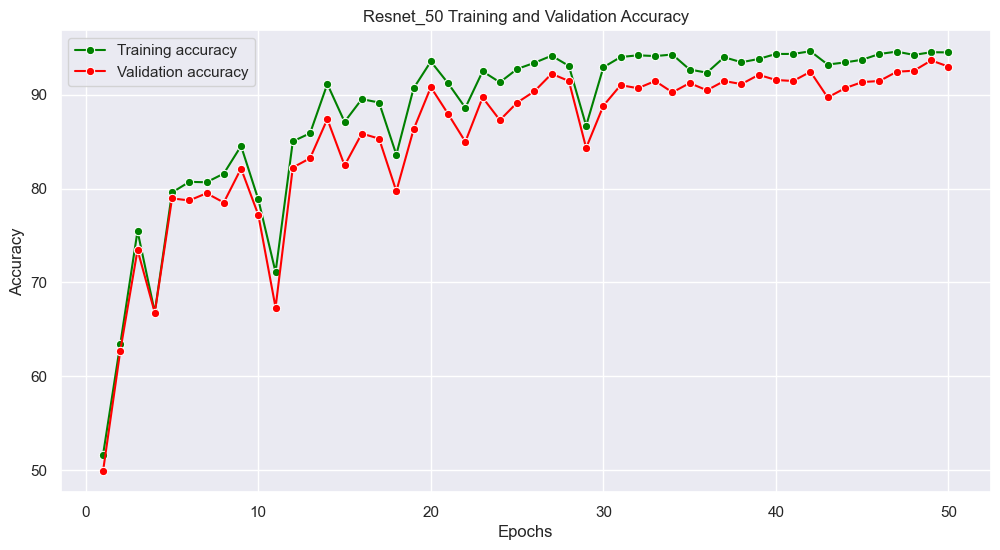

In [49]:
sns.set(style='darkgrid') 
plt.figure(figsize=(12, 6))
sns.lineplot(x = epochs,y = train_accuracy_lis, label='Training accuracy', marker='o', color='green')
sns.lineplot(x = epochs,y = val_accuracy_lis, label='Validation accuracy', marker='o', color='red')
plt.title('Resnet_50 Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.savefig(os.path.join(folder_name, 'Resnet50_accuracy_plot.png'))
plt.show()

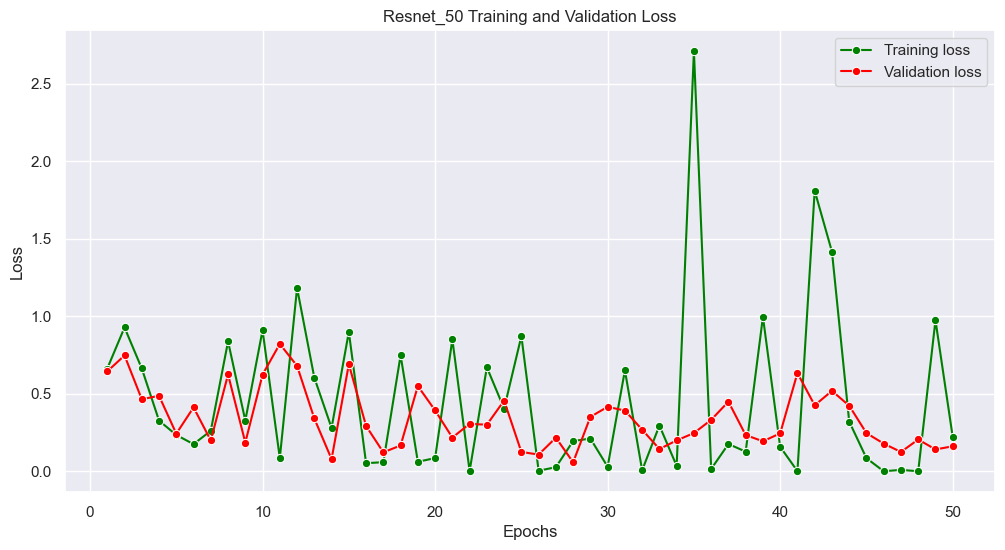

In [50]:
plt.figure(figsize=(12, 6))
sns.lineplot(x = epochs,y = loss_epoch_arr, label='Training loss', marker='o', color='green')
sns.lineplot(x = epochs, y = val_loss_epoch_arr, label='Validation loss', marker='o', color='red')
plt.title('Resnet_50 Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.savefig(os.path.join(folder_name, 'Resnet_50_loss_plot.png'))
plt.show()

In [51]:
all_preds, all_labels = plot_evaluation_metrics(resnet,valloader,device)

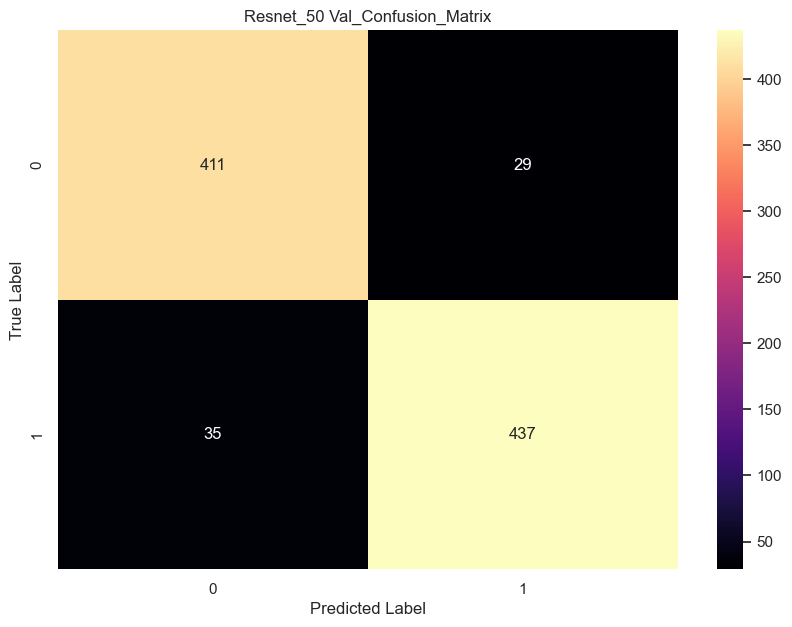

In [52]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d',cmap = "magma")
plt.title('Resnet_50 Val_Confusion_Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(folder_name, 'Resnet_50_Val_Confusion_Matrix.png'))
plt.show()

In [53]:
generate_classification_report(resnet,valloader, device, 'Resnet_50_results/Val_report.txt')

Classification report saved to 'Resnet_50_results/Val_report.txt'


In [54]:
all_preds, all_labels = plot_evaluation_metrics(resnet,testloader,device)

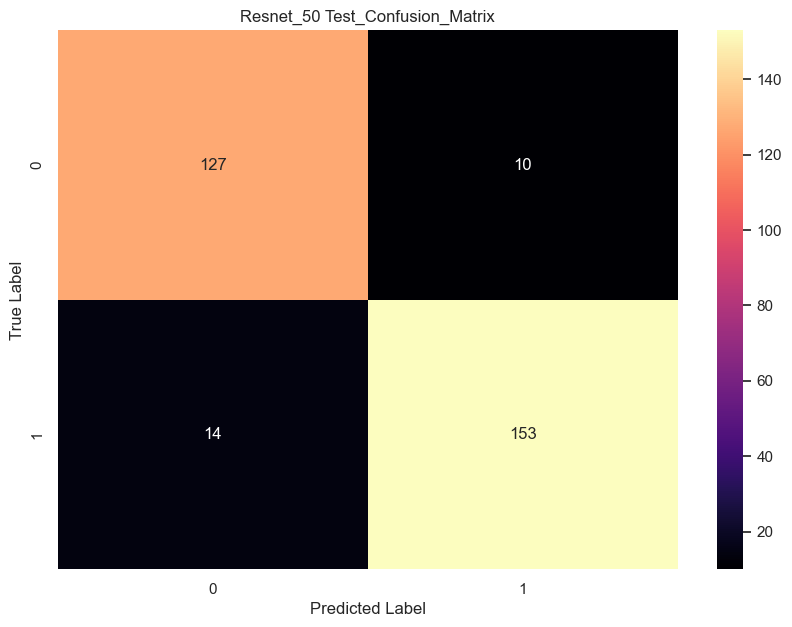

In [55]:
cm = confusion_matrix(all_labels, all_preds)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d',cmap = "magma")
plt.title('Resnet_50 Test_Confusion_Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.savefig(os.path.join(folder_name, 'Resnet_50_Test_Confusion_Matrix.png'))
plt.show()

In [56]:
generate_classification_report(resnet,testloader, device, 'Resnet_50_results/Test_report.txt')

Classification report saved to 'Resnet_50_results/Test_report.txt'


# Resnet-152

In [57]:
resnet = models.resnet152(weights=True)

C:\Users\BTBM\anaconda3\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet152_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet152_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [58]:
for param in resnet.parameters():
    param.requires_grad=True

In [59]:
num_features = resnet.fc.in_features
new_classifier = nn.Sequential(
    nn.Linear(num_features, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2))
resnet.fc = new_classifier

In [60]:
resnet =resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.0001)
summary(resnet, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]           4,096
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]          16,384
      BatchNorm2d-12          [-1, 256, 56, 56]             512
           Conv2d-13          [-1, 256, 56, 56]          16,384
      BatchNorm2d-14          [-1, 256,

In [61]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)


In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(resnet, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

  0%|          | 0/50 [00:00<?, ?epochs/s]

Min loss 0.71
Iteration: 0, Loss: 0.71
Min loss 0.68
Min loss 0.68
Min loss 0.66
Min loss 0.65
Min loss 0.64
Min loss 0.62
Min loss 0.61
Min loss 0.58
Min loss 0.58
Min loss 0.58
Epoch: 0/50, Test acc: 50.99, Train acc: 52.13
Iteration: 0, Loss: 0.70
Min loss 0.57
Min loss 0.56
Min loss 0.56
Min loss 0.55
Min loss 0.55
Min loss 0.53
Min loss 0.38
Epoch: 1/50, Test acc: 67.98, Train acc: 67.29
Iteration: 0, Loss: 0.62
Epoch: 2/50, Test acc: 67.98, Train acc: 66.74
Iteration: 0, Loss: 0.53
Epoch: 3/50, Test acc: 69.85, Train acc: 71.54
Iteration: 0, Loss: 0.54
Min loss 0.37
Epoch: 4/50, Test acc: 73.68, Train acc: 74.75
Iteration: 0, Loss: 0.43
Min loss 0.35
Min loss 0.34
Min loss 0.33
Min loss 0.31
Epoch: 5/50, Test acc: 64.91, Train acc: 69.02
Iteration: 0, Loss: 0.35
Min loss 0.26
Epoch: 6/50, Test acc: 76.10, Train acc: 77.38
Iteration: 0, Loss: 0.37
Min loss 0.24
Min loss 0.23
Epoch: 7/50, Test acc: 72.92, Train acc: 77.58
Iteration: 0, Loss: 0.47
Min loss 0.23
Epoch: 8/50, Test acc

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,resnet)

# Resnet 18

In [ ]:
resnet = models.resnet18(weights=True)

In [ ]:
for param in resnet.parameters():
    param.requires_grad=False

In [ ]:
num_features = resnet.fc.in_features
new_classifier = nn.Sequential(
    nn.Linear(num_features, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2))
resnet.fc = new_classifier

In [ ]:
resnet =resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.0001)
summary(resnet, (3, 224, 224))

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)


In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(resnet, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,resnet)

# resnet-34

In [ ]:
resnet = models.resnet34(weights=True)

In [ ]:
for param in resnet.parameters():
    param.requires_grad=False

In [ ]:
num_features = resnet.fc.in_features
new_classifier = nn.Sequential(
    nn.Linear(num_features, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2))
resnet.fc = new_classifier

In [ ]:
resnet =resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.0001)
summary(resnet, (3, 224, 224))

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)


In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(resnet, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,resnet)

# resnet 101

In [ ]:
resnet = models.resnet101(weights=True)

In [ ]:
for param in resnet.parameters():
    param.requires_grad=False

In [ ]:
num_features = resnet.fc.in_features
new_classifier = nn.Sequential(
    nn.Linear(num_features, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2))
resnet.fc = new_classifier

In [ ]:
resnet =resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.0001)
summary(resnet, (3, 224, 224))

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)


In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(resnet, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,resnet)

# VGG-16

In [ ]:
vgg16 = models.vgg16_bn(pretrained=True)

In [ ]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 2)

In [ ]:
vgg16 = vgg16.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(vgg16.parameters(), lr=0.0001)

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)

In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(vgg16, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,vgg16)

# VGG-19

In [ ]:
vgg19 = models.vgg19_bn(pretrained=True)

In [ ]:
for param in vgg19.features.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(num_features, 2)

In [ ]:
vgg19 = vgg19.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(vgg19.parameters(), lr=0.0001)

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)

In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(vgg19, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,vgg19)

# Densenet121

In [ ]:
densenet121 = models.densenet121(pretrained=True)

In [ ]:
for param in densenet121.features.parameters():
    param.requires_grad = False


In [ ]:
num_features = densenet121.classifier.in_features
densenet121.classifier = nn.Linear(num_features, 2)

In [ ]:
densenet121 = densenet121.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(densenet121.parameters(), lr=0.0001)

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)

In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(densenet121, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,densenet121)

# DenseNet201

In [ ]:
densenet201 = models.densenet201(weights=True)

In [ ]:
for param in densenet201.features.parameters():
    param.requires_grad = True

In [ ]:
num_features = densenet201.classifier.in_features
densenet201.classifier = nn.Linear(num_features, 2)

In [ ]:
densenet201 = densenet201.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(densenet201.parameters(), lr=0.001)

In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(densenet201, loss_fn, opt, trainloader, valloader, scheduler , epochs=100
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,densenet201)

In [ ]:
densenet201b= models.densenet201(weights=False)

In [ ]:
for param in densenet201b.features.parameters():
    param.requires_grad = True

In [ ]:
num_features = densenet201b.classifier.in_features
densenet201b.classifier = nn.Linear(num_features, 2)

In [ ]:
densenet201b = densenet201b.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(densenet201b.parameters(), lr=0.001)

In [ ]:
best_modelb, loss_epoch_arrb, train_accuracy_lisb, val_accuracy_lisb, val_loss_epoch_arrb = train_func(densenet201b, loss_fn, opt, trainloader, valloader, scheduler , epochs=100
                                                                            )      

In [ ]:
testloaderb = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloaderb,densenet201b)

# Data1

In [ ]:
data_dir='G:\DCDA-Net\Data_1'
print(os.listdir(data_dir))

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

In [ ]:
transform = transforms.Compose([
                transforms.ToTensor(),
                transforms.Resize(size=(224,224)),
                transforms.Normalize((0.3570, 0.7503, 0.5559), (0.3445, 0.0633, 0.2608))
                ])

In [ ]:
dataset=ImageFolder(data_dir,transform=transform)
torch.manual_seed(42)
train_ds, val_ds, test_ds = random_split(dataset, [0.8,0.15,0.05])
len(train_ds),len(val_ds),len(test_ds)

In [ ]:
trainloader =DataLoader(train_ds, batch_size=16, shuffle=True,num_workers=4)
valloader = DataLoader(val_ds, batch_size=32, shuffle=True,num_workers=4)

In [ ]:
def evaluation(dataloader, model):
    total, correct = 0, 0
    model.eval()
    for data in dataloader:
        inputs, labels = data
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, pred = torch.max(outputs.data, 1)

        total += labels.size(0)
        correct += (pred == labels).sum().item()
    return 100 * correct / total

In [ ]:
def train_func(model, loss_fn, opt, trainloader, valloader, scheduler , epochs=50):
    loss_epoch_arr = []
    train_accuracy_lis = []
    val_accuracy_lis = []
    val_loss_epoch_arr = []

    max_epochs = epochs
    min_loss = 1000
    model.train()

    for epoch in notebook.tqdm(range(max_epochs), total=max_epochs, unit="epochs"):
        model.train()
        for i, data in enumerate(trainloader, 0):
    
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            opt.zero_grad()
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            opt.step()
            scheduler.step()

            if min_loss > loss.item():
                min_loss = loss.item()
                best_model = copy.deepcopy(model.state_dict())
                print("Min loss %0.2f" %min_loss)
            del inputs, labels, outputs
            if torch.cuda.is_available():
                torch.cuda.empty_cache()
            if i % 2000 == 0:
                print('Iteration: %d, Loss: %0.2f' % (i, loss.item()))
            
       
        loss_epoch_arr.append(loss.item())
        train_accuracy = evaluation(trainloader, model)
        val_accuracy = evaluation(valloader, model)
        print('Epoch: %d/%d, Test acc: %0.2f, Train acc: %0.2f' % (
              epoch, max_epochs, val_accuracy, train_accuracy))
        train_accuracy_lis.append(train_accuracy)
        val_accuracy_lis.append(val_accuracy)
    
        model.eval()
        with torch.no_grad():
            for i, data in enumerate(valloader, 0):
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = loss_fn(outputs, labels)

        del inputs, labels, outputs
        if torch.cuda.is_available():
            torch.cuda.empty_cache()

        val_loss_epoch_arr.append(loss.item())
    return best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr

# Resnet50

In [ ]:
resnet = models.resnet50(weights=True)

In [ ]:
for param in resnet.parameters():
    param.requires_grad=False

In [ ]:
num_features = resnet.fc.in_features
new_classifier = nn.Sequential(
    nn.Linear(num_features, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2))
resnet.fc = new_classifier

In [ ]:
resnet =resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.0001)
summary(resnet, (3, 224, 224))

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)


In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(resnet, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,resnet)

# Resnet-152

In [ ]:
resnet = models.resnet152(weights=True)

In [ ]:
for param in resnet.parameters():
    param.requires_grad=False

In [ ]:
num_features = resnet.fc.in_features
new_classifier = nn.Sequential(
    nn.Linear(num_features, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2))
resnet.fc = new_classifier

In [ ]:
resnet =resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.0001)
summary(resnet, (3, 224, 224))

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)


In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(resnet, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,resnet)

# Resnet 18

In [ ]:
resnet = models.resnet18(weights=True)

In [ ]:
for param in resnet.parameters():
    param.requires_grad=False

In [ ]:
num_features = resnet.fc.in_features
new_classifier = nn.Sequential(
    nn.Linear(num_features, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2))
resnet.fc = new_classifier

In [ ]:
resnet =resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.0001)
summary(resnet, (3, 224, 224))

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)


In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(resnet, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,resnet)

# resnet-34

In [ ]:
resnet = models.resnet34(weights=True)

In [ ]:
for param in resnet.parameters():
    param.requires_grad=False

In [ ]:
num_features = resnet.fc.in_features
new_classifier = nn.Sequential(
    nn.Linear(num_features, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2))
resnet.fc = new_classifier

In [ ]:
resnet =resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.0001)
summary(resnet, (3, 224, 224))

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)


In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(resnet, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,resnet)

# resnet 101

In [ ]:
resnet = models.resnet101(weights=True)

In [ ]:
for param in resnet.parameters():
    param.requires_grad=False

In [ ]:
num_features = resnet.fc.in_features
new_classifier = nn.Sequential(
    nn.Linear(num_features, 256), nn.ReLU(), nn.Dropout(0.2),
    nn.Linear(256, 2))
resnet.fc = new_classifier

In [ ]:
resnet =resnet.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(resnet.parameters(), lr=0.0001)
summary(resnet, (3, 224, 224))

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)


In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(resnet, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,resnet)

# VGG-16

In [ ]:
vgg16 = models.vgg16_bn(pretrained=True)

In [ ]:
for param in vgg16.features.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg16.classifier[6].in_features
vgg16.classifier[6] = nn.Linear(num_features, 2)

In [ ]:
vgg16 = vgg16.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(vgg16.parameters(), lr=0.0001)

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)

In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(vgg16, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,vgg16)

# VGG-19

In [ ]:
vgg19 = models.vgg19_bn(pretrained=True)

In [ ]:
for param in vgg19.features.parameters():
    param.requires_grad = False

In [ ]:
num_features = vgg19.classifier[6].in_features
vgg19.classifier[6] = nn.Linear(num_features, 2)

In [ ]:
vgg19 = vgg19.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(vgg19.parameters(), lr=0.0001)

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)

In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(vgg19, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,vgg19)

# Densenet121

In [ ]:
densenet121 = models.densenet121(pretrained=True)

In [ ]:
for param in densenet121.features.parameters():
    param.requires_grad = False


In [ ]:
num_features = densenet121.classifier.in_features
densenet121.classifier = nn.Linear(num_features, 2)

In [ ]:
densenet121 = densenet121.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(densenet121.parameters(), lr=0.0001)

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)

In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(densenet121, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,densenet121)

# DenseNet201

In [ ]:
densenet201 = models.densenet201(pretrained=True)

In [ ]:
for param in densenet201.features.parameters():
    param.requires_grad = False

In [ ]:
num_features = densenet201.classifier.in_features
densenet201.classifier = nn.Linear(num_features, 2)

In [ ]:
densenet201 = densenet201.to(device)
loss_fn = nn.CrossEntropyLoss()
opt = optim.Adam(densenet201.parameters(), lr=0.0001)

In [ ]:
steps_per_epoch = len(trainloader)

# Set the maximum learning rate and the factor by which to increase it
max_lr = 0.01
lr_step_factor = 8

# Define the learning rate scheduler with the OneCycleLR policy
scheduler = lr_scheduler.OneCycleLR(opt, max_lr, total_steps=50* steps_per_epoch, pct_start=0.3, div_factor=lr_step_factor)

In [ ]:
best_model, loss_epoch_arr, train_accuracy_lis, val_accuracy_lis, val_loss_epoch_arr = train_func(densenet201, loss_fn, opt, trainloader, valloader, scheduler , epochs=50
                                                                            )      

In [ ]:
testloader = DataLoader(test_ds, batch_size=32, shuffle=False)

In [ ]:
evaluation(testloader,densenet201)

## Densenet 264